In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")



In [2]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

%memit wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))

loaded @200819.17:09:44
took 43.85-s to load data
peak memory: 38649.67 MiB, increment: 38451.75 MiB


In [3]:
wtt

AnnData object with n_obs × n_vars = 164722 × 26374
    obs: 'batch', 'genotype', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'stored_ctype', 'ctype', 'value'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed'
    obsp: 'connectivities', 'distances'

In [2]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

%memit wtt = utils.load_adata(os.path.join(pdfp, 'mouse_wt_imputed.h5ad'))
%memit mutt = utils.load_adata(os.path.join(pdfp, 'mouse_sca1_imputed.h5ad'))

loaded @200814.09:57:44
took 39.68-s to load data
peak memory: 38651.81 MiB, increment: 38455.41 MiB
loaded @200814.09:58:20
took 35.68-s to load data
peak memory: 74509.39 MiB, increment: 35857.56 MiB


In [3]:
# MELD per genotype AND ctype
if False:
    goi = ['Clstn2','Camk1d','Plk5',
           'Srsf7','Slc15a2','Calb2',
           'Slit3','Sdk1',]

    X = pd.DataFrame()
    for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 
                                'Oligodendrocyte', 'Astrocyte', 'Unipolar brush cell', 
                                'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 
                                'Endothelial cell', 'Pericyte', 'GABAergic interneuron 3',  
                                'Granule cell']):

        print('\nStarting {}'.format(ctype))
        print('----\n')
        tic = time.time()

        recalculate = True # gives option to tshoot

        if recalculate:
            if ctype=='Granule cell': 
                # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
                nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
                wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
                nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
                mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
            else:
                wt = wtt[(wtt.obs['ctype']==ctype), :]
                wt.obs['value'] = 0
                mut = mutt[(mutt.obs['ctype']==ctype), :]
                mut.obs['value'] = 0

            sc.pp.pca(wt)
            sc.pp.neighbors(wt, n_pcs=50)
            sc.pp.pca(mut)
            sc.pp.neighbors(mut, n_pcs=50)

            if False:
                wt = utils.adata_phate(wt)
                mut = utils.adata_phate(mut)

            # MELD
            G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                         precomputed='adjacency',
                         use_pygsp=True)
            G.knn_max = None
            wt.obs['res_t']=-1
            wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
            wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
            wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
            wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
            wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
            wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

            del G

            G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
            G.knn_max = None
            mut.obs['res_t']=-1
            mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
            mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
            mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
            mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
            mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
            mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())

            del G

            # store in X of interest
            x_wt = pd.DataFrame(wt[:, goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi)
            x_wt['genotype'] = wt.obs['genotype'].to_list()
            x_wt['timepoint'] = wt.obs['timepoint'].to_list()
            x_wt['ctype'] = wt.obs['ctype'].to_list()
            x_wt['Pseudotime'] = wt.obs['ees_t'].to_list()

            x_mut = pd.DataFrame(mut[:, goi].layers['imputed'], index=mut.obs.index.to_list(), columns=goi)
            x_mut['genotype'] = mut.obs['genotype'].to_list()
            x_mut['timepoint'] = mut.obs['timepoint'].to_list()
            x_mut['ctype'] = mut.obs['ctype'].to_list()
            x_mut['Pseudotime'] = mut.obs['ees_t'].to_list()

            X = X.append(x_wt.append(x_mut))

            del x_wt, x_mut, wt, mut

            print('  done in {}-s'.format(time.time() - tic))

In [ ]:
if False:
    # calculate meld per ctype
    goi = ['Clstn2','Camk1d','Plk5',
           'Srsf7','Slc15a2','Calb2',
           'Slit3','Sdk1',]

    X = pd.DataFrame()
    for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 
                                'Oligodendrocyte', 'Astrocyte', 'Unipolar brush cell', 
                                'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 
                                'Endothelial cell', 'Pericyte', 'GABAergic interneuron 3',]):  
    #                             'Granule cell']):

        print('\nStarting {}'.format(ctype))
        print('----\n')
        tic = time.time()

        recalculate = True # gives option to tshoot

        if recalculate:


            if ctype=='Granule cell': 
                # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
                n_samples = 10000
                nsample_idx_wt = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(n_samples).index.to_list()

                nsample_idx_mut = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(n_samples).index.to_list()
                tdata = sc.AnnData(X=np.concatenate((wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx_wt))].layers['imputed'], 
                                                     mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx_mut))].layers['imputed'])),
                                   obs=wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx_wt))].obs.append(mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx_mut))].obs), 
                                   var=wtt.var)
                tdata.obs['value'] = 0
            else:
                # use imputed for MELD
                tdata = sc.AnnData(X=np.concatenate((wtt[(wtt.obs['ctype']==ctype), :].layers['imputed'], 
                                                     mutt[(mutt.obs['ctype']==ctype), :].layers['imputed'])),
                                   obs=wtt[(wtt.obs['ctype']==ctype), :].obs.append(mutt[(mutt.obs['ctype']==ctype), :].obs), 
                                   var=wtt.var)
                tdata.obs['value'] = 0

            sc.pp.pca(tdata)
            sc.pp.neighbors(tdata, n_pcs=50)

            # MELD
            G = gt.Graph(data=tdata.obsp['connectivities']+sparse.diags([1]*tdata.shape[0],format='csr'),
                         precomputed='adjacency',
                         use_pygsp=True)
            G.knn_max = None
            tdata.obs['res_t']=-1
            tdata.obs.loc[tdata.obs['timepoint']=='12wk', 'res_t'] = -0.5
            tdata.obs.loc[tdata.obs['timepoint']=='18wk', 'res_t'] = 0
            tdata.obs.loc[tdata.obs['timepoint']=='24wk', 'res_t'] = 0.5
            tdata.obs.loc[tdata.obs['timepoint']=='30wk', 'res_t'] = 1
            tdata.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=tdata.obs['res_t'])
            tdata.obs['ees_t'] = (tdata.obs['ees_t'] - tdata.obs['ees_t'].min()) / (tdata.obs['ees_t'].max() - tdata.obs['ees_t'].min())

            del G

            # store in X of interest
            x = pd.DataFrame(np.asarray(tdata[:, goi].X), index=tdata.obs.index.to_list(), columns=goi)
            x['genotype'] = tdata.obs['genotype'].to_list()
            x['timepoint'] = tdata.obs['timepoint'].to_list()
            x['ctype'] = tdata.obs['ctype'].to_list()
            x['Pseudotime'] = tdata.obs['ees_t'].to_list()

            X = X.append(x)

            del x, tdata

            print('  done in {}-s'.format(time.time() - tic))

In [ ]:
if False:
    goi = ['Clstn2','Camk1d','Plk5',
       'Srsf7','Slc15a2','Calb2',
       'Slit3','Sdk1',]
    
    recalculate = False
    
    if recalculate:
        # global MELD 
        %memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))

        # MELD
        G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        adata.obs['res_t']=-1
        adata.obs.loc[adata.obs['timepoint']=='12wk', 'res_t'] = -0.5
        adata.obs.loc[adata.obs['timepoint']=='18wk', 'res_t'] = 0
        adata.obs.loc[adata.obs['timepoint']=='24wk', 'res_t'] = 0.5
        adata.obs.loc[adata.obs['timepoint']=='30wk', 'res_t'] = 1
        adata.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=adata.obs['res_t'])
        adata.obs['ees_t'] = (adata.obs['ees_t'] - adata.obs['ees_t'].min()) / (adata.obs['ees_t'].max() - adata.obs['ees_t'].min())

        del G

        # add these to the imputed data
        wtt.obs = wtt.obs.join(adata.obs['ees_t'])
        mutt.obs = mutt.obs.join(adata.obs['ees_t'])

        # clear space
        del adata
    
    # aggregate imputed data and pseudotime
    X = pd.DataFrame()
    for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 
                                'Oligodendrocyte', 'Astrocyte', 'Unipolar brush cell', 
                                'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 
                                'Endothelial cell', 'Pericyte', 'GABAergic interneuron 3',#]):  
                                    'Granule cell']):

        print('\nStarting {}'.format(ctype))
        print('----\n')
        tic = time.time()

        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0


        # store in X of interest
        x_wt = pd.DataFrame(wt[:, goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi)
        x_wt['genotype'] = wt.obs['genotype'].to_list()
        x_wt['timepoint'] = wt.obs['timepoint'].to_list()
        x_wt['ctype'] = wt.obs['ctype'].to_list()
        x_wt['Pseudotime'] = wt.obs['ees_t'].to_list()

        x_mut = pd.DataFrame(mut[:, goi].layers['imputed'], index=mut.obs.index.to_list(), columns=goi)
        x_mut['genotype'] = mut.obs['genotype'].to_list()
        x_mut['timepoint'] = mut.obs['timepoint'].to_list()
        x_mut['ctype'] = mut.obs['ctype'].to_list()
        x_mut['Pseudotime'] = mut.obs['ees_t'].to_list()

        X = X.append(x_wt.append(x_mut))

        del x_wt, x_mut, wt, mut

        print('  done in {}-s'.format(time.time() - tic))
    

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


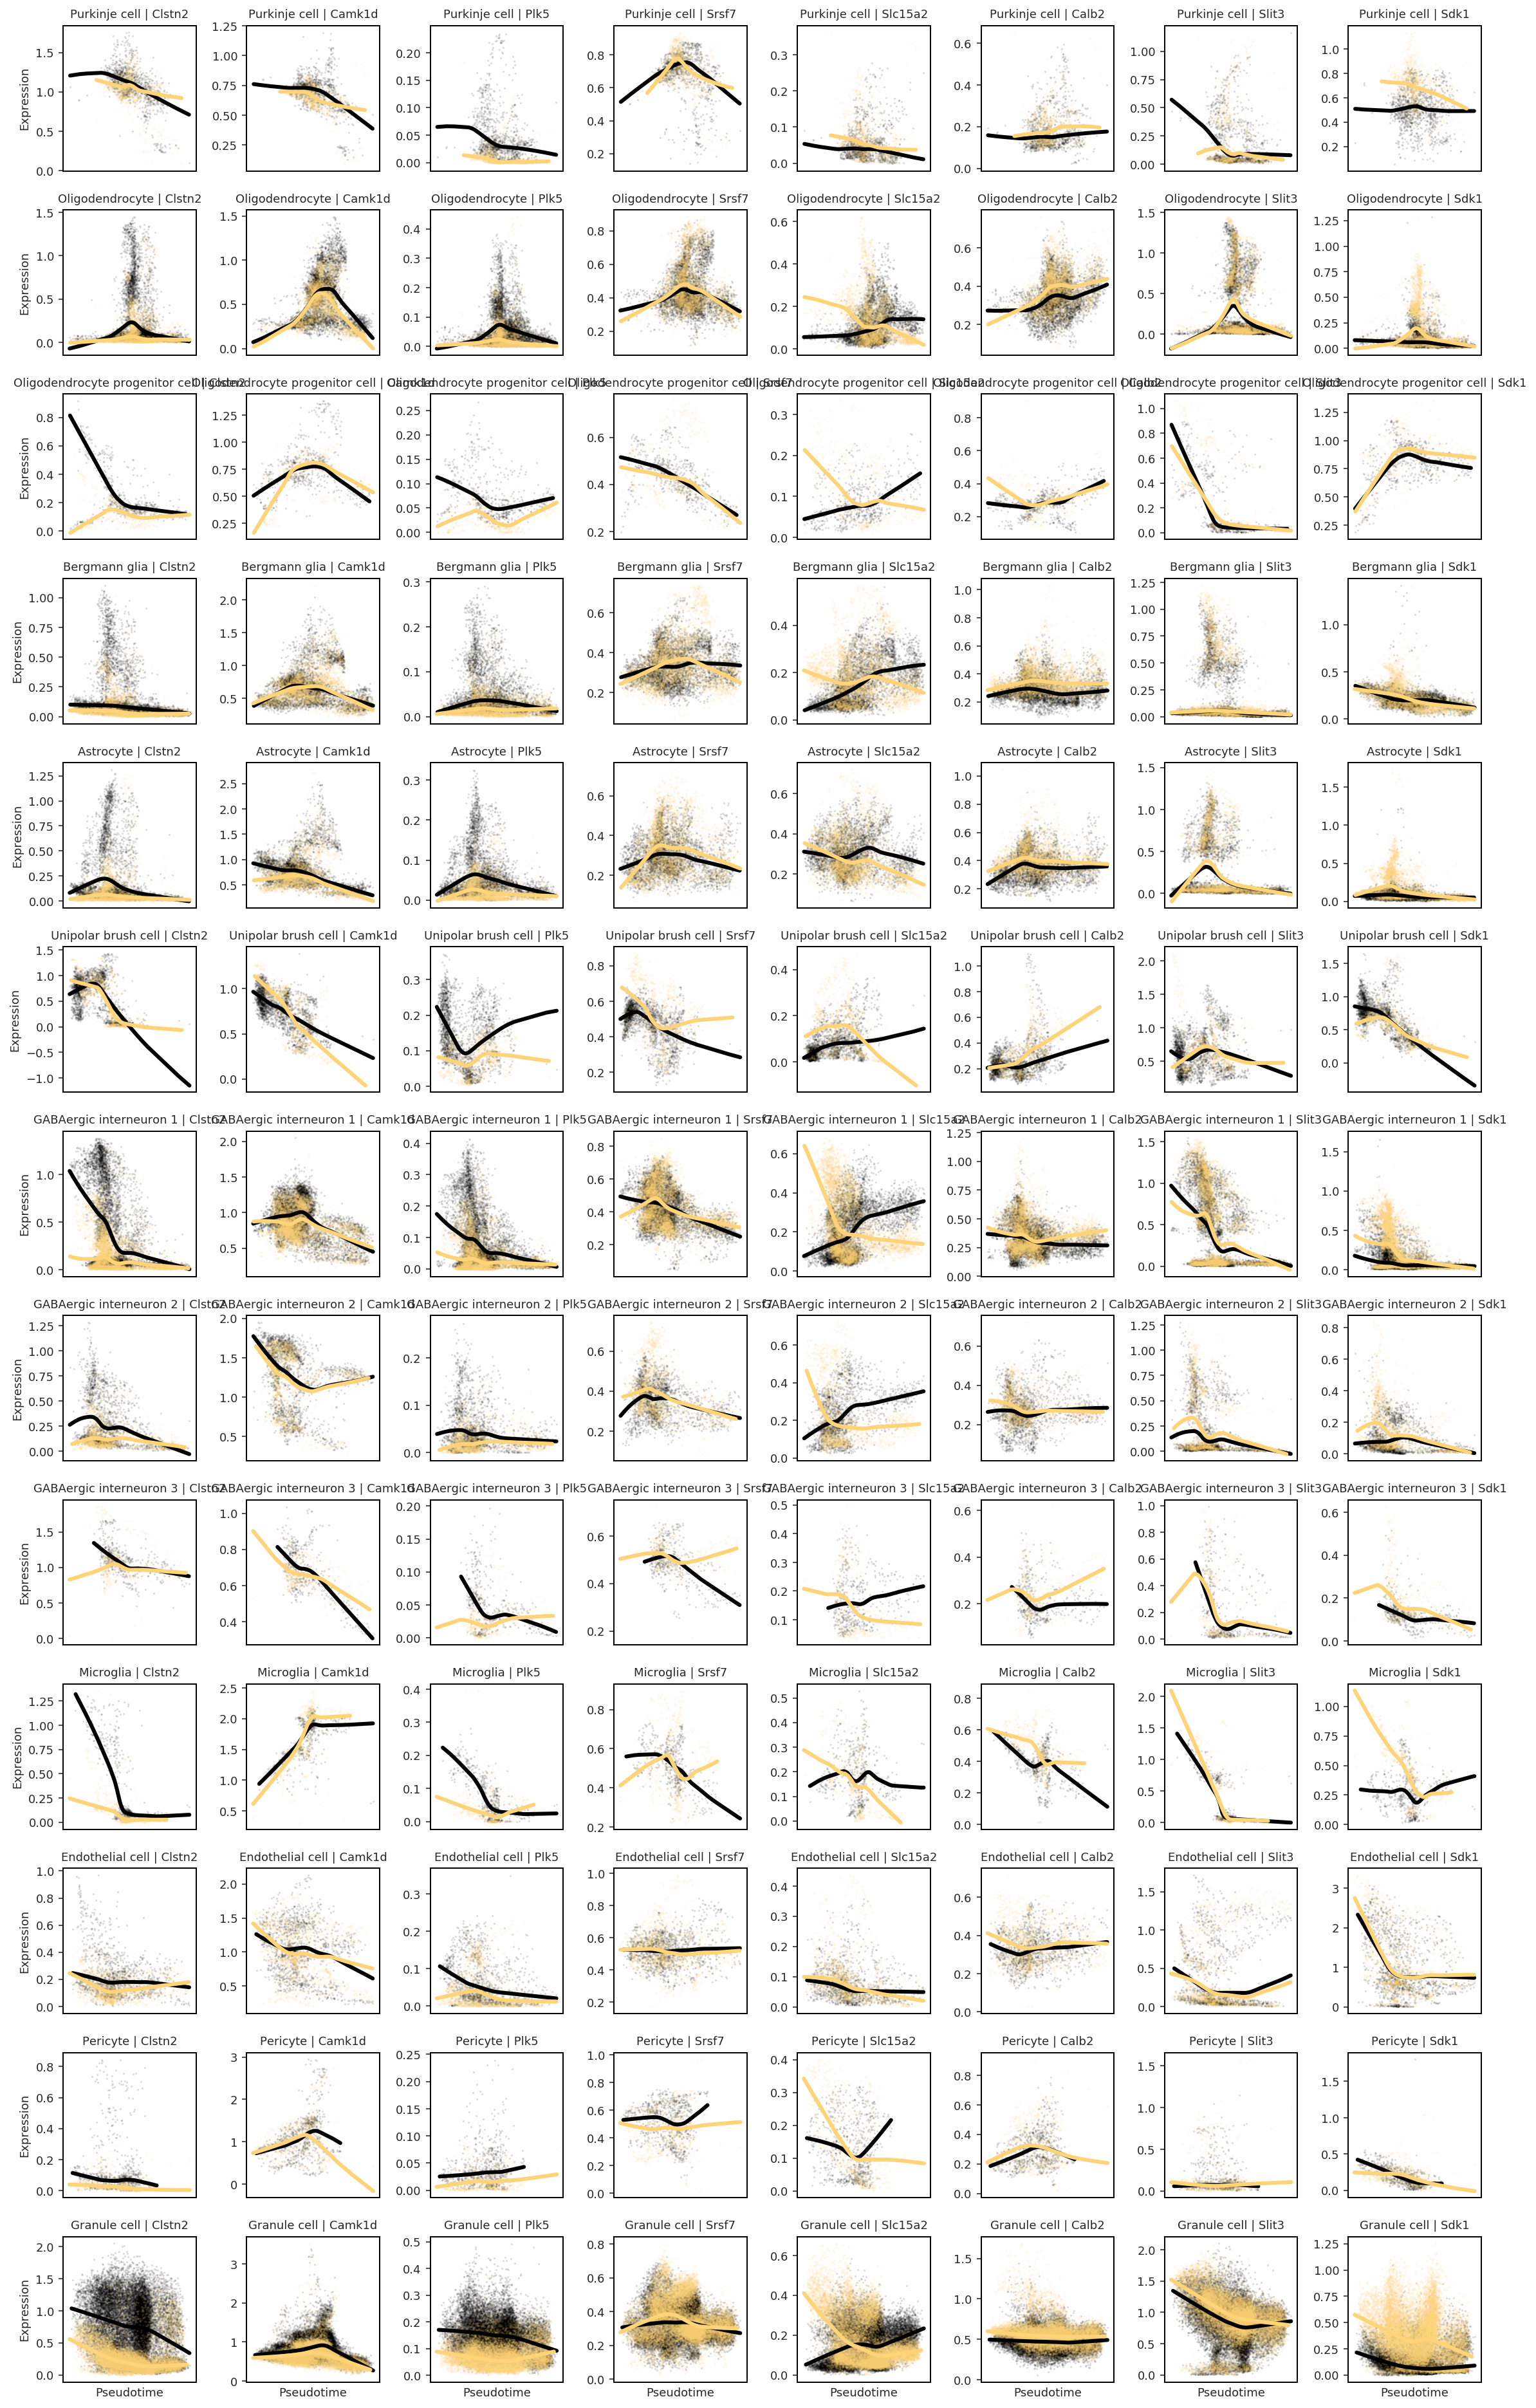

In [16]:
fname = 'top5wk_allMELD'

# aesthetics
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}

# plot
x = X.melt(
    id_vars=['genotype','timepoint','ctype','Pseudotime'],
    value_vars=goi,
    var_name='Gene',
    value_name='Expression',
    col_level=None)


p = sns.lmplot(
    x='Pseudotime',
    y='Expression',
    data=x,
    hue='genotype',
    col='Gene',
    row='ctype',
    palette=cmap_genotype,
#     col_wrap=3,
    height=2,
    aspect=1,
    markers='o',
    sharex=False,
    sharey=False,
    hue_order=None,
    col_order=goi,
    row_order=['Purkinje cell', 'Oligodendrocyte', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 'Astrocyte', 'Unipolar brush cell', 
                            'GABAergic interneuron 1', 'GABAergic interneuron 2', 'GABAergic interneuron 3', 'Microglia',  'Endothelial cell', 'Pericyte', 
                            'Granule cell'],
    legend=False,
    legend_out=True,
    x_estimator=None,
    x_bins=None,
    x_ci='ci',
    scatter=True,
    fit_reg=True,
    ci=None,
    n_boot=100,
    units=None,
    seed=None,
    order=1,
    logistic=False,
    lowess=True,
    robust=False,
    logx=False,
    x_partial=None,
    y_partial=None,
    truncate=True,
    x_jitter=None,
    y_jitter=None,
    scatter_kws={'s':0.5,'alpha':0.1,'rasterized':True},
    line_kws={'linewidth':3},
    size=None,
)
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')
p.set(xticks=[])
for ax in p.axes.flatten(): # Loop directly on the flattened axes 
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)
    
p.savefig(os.path.join(pfp,'dyn_goi_{}.pdf'.format(fname)),bbox_inches='tight',dpi=300)

# Per ctype

In [6]:
if True:
    goi_dict = {
        'Astrocyte':['Daam2'],
        'Bergmann glia':['Etv5'],
        'GABAergic interneuron 1':['Clmp'],
        'Microglia':['Camk1d'],
        'Oligodendrocyte':['Fnbp1','Plp1', 'Enpp2', 'Onecut2'],
        'Oligodendrocyte progenitor cell':['Etv5', 'Kcnh8', 'Sdk1','Ncam2'],
        'Pericyte':['Ttr','Qrich2'],
        'Purkinje cell':['Car8','Pcp2', 'Paxbp1',],
        'Unipolar brush cell':['Snca', 'Slit3', 'Sv2c'],}
                                           
    goi = list(set([g for k,v in goi_dict.items() for g in v]))
    
    recalculate = True
    
    if recalculate:
        # global MELD 
        %memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))

        # MELD
        G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        adata.obs['res_t']=-1
        adata.obs.loc[adata.obs['timepoint']=='12wk', 'res_t'] = -0.5
        adata.obs.loc[adata.obs['timepoint']=='18wk', 'res_t'] = 0
        adata.obs.loc[adata.obs['timepoint']=='24wk', 'res_t'] = 0.5
        adata.obs.loc[adata.obs['timepoint']=='30wk', 'res_t'] = 1
        adata.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=adata.obs['res_t'])
        adata.obs['ees_t'] = (adata.obs['ees_t'] - adata.obs['ees_t'].min()) / (adata.obs['ees_t'].max() - adata.obs['ees_t'].min())

        del G

        # add these to the imputed data
        wtt.obs = wtt.obs.join(adata.obs['ees_t'])
        mutt.obs = mutt.obs.join(adata.obs['ees_t'])

        # clear space
        del adata
    
    # aggregate imputed data and pseudotime
    X = pd.DataFrame()
    for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 
                                'Oligodendrocyte', 'Astrocyte', 'Unipolar brush cell', 
                                'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 
                                'Endothelial cell', 'Pericyte', 'GABAergic interneuron 3',#]):  
                                    'Granule cell']):

        print('\nStarting {}'.format(ctype))
        print('----\n')
        tic = time.time()

        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0


        # store in X of interest
        x_wt = pd.DataFrame(wt[:, goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi)
        x_wt['genotype'] = wt.obs['genotype'].to_list()
        x_wt['timepoint'] = wt.obs['timepoint'].to_list()
        x_wt['ctype'] = wt.obs['ctype'].to_list()
        x_wt['Pseudotime'] = wt.obs['ees_t'].to_list()

        x_mut = pd.DataFrame(mut[:, goi].layers['imputed'], index=mut.obs.index.to_list(), columns=goi)
        x_mut['genotype'] = mut.obs['genotype'].to_list()
        x_mut['timepoint'] = mut.obs['timepoint'].to_list()
        x_mut['ctype'] = mut.obs['ctype'].to_list()
        x_mut['Pseudotime'] = mut.obs['ees_t'].to_list()

        X = X.append(x_wt.append(x_mut))

        del x_wt, x_mut, wt, mut

        print('  done in {}-s'.format(time.time() - tic))
    

loaded @200804.09:56:55
took 20.38-s to load data
peak memory: 85038.89 MiB, increment: 10526.98 MiB


Trying to set attribute `.obs` of view, copying.



Starting Purkinje cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.9802191257476807-s

Starting Oligodendrocyte progenitor cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.4994194507598877-s

Starting Bergmann glia
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 3.032406806945801-s

Starting Oligodendrocyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 2.8670871257781982-s

Starting Astrocyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 2.5410022735595703-s

Starting Unipolar brush cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.9697189331054688-s

Starting GABAergic interneuron 1
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 4.2650346755981445-s

Starting Microglia
----



Trying to set attribute `.obs` of view, copying.


  done in 0.48795413970947266-s

Starting GABAergic interneuron 2
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 1.334402322769165-s

Starting Endothelial cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 1.179720401763916-s

Starting Pericyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.5103764533996582-s

Starting GABAergic interneuron 3
----

  done in 0.3804206848144531-s

Starting Granule cell
----

  done in 1.3195116519927979-s


In [7]:

# aesthetics
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}

# plot
x = X.melt(
    id_vars=['genotype','timepoint','ctype','Pseudotime'],
    value_vars=goi,
    var_name='Gene',
    value_name='Expression',
    col_level=None)

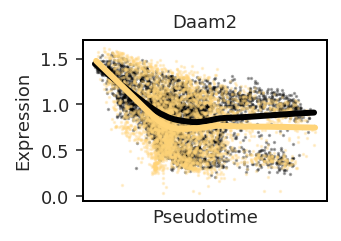

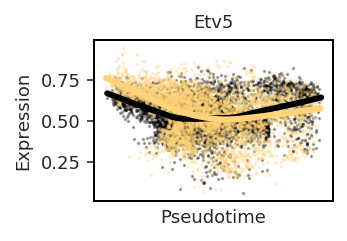

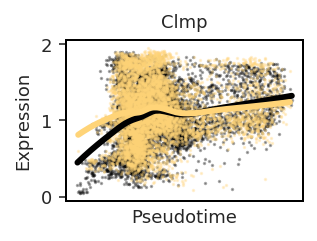

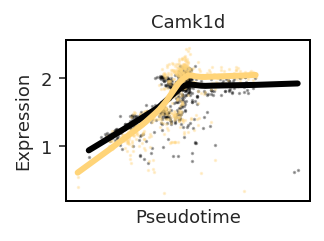

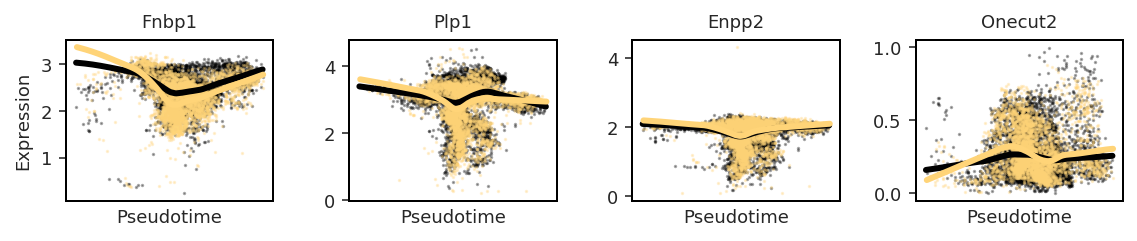

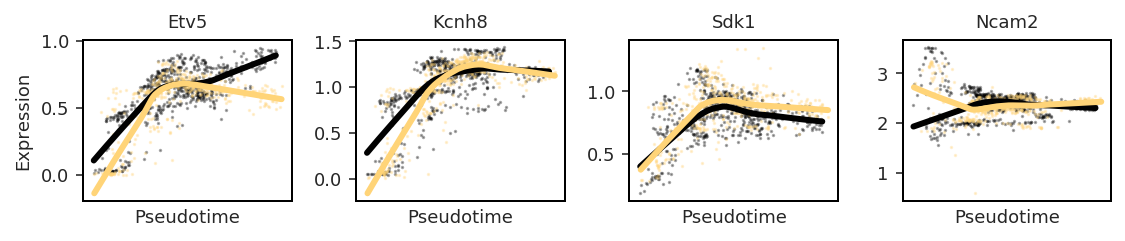

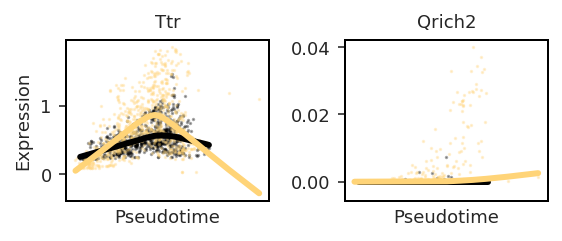

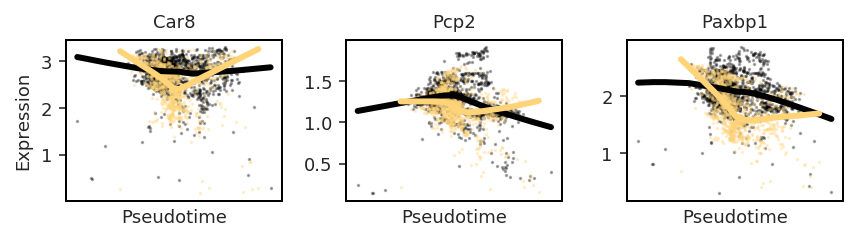

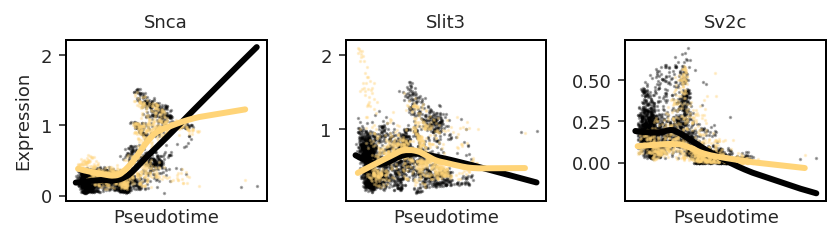

In [9]:

for i in goi_dict.keys():
    x_i = x.loc[(x['ctype']==i) & x['Gene'].isin(goi_dict[i]), :]

    p = sns.lmplot(
        x='Pseudotime',
        y='Expression',
        data=x_i,
        hue='genotype',
        col='Gene',
        palette=cmap_genotype,
        col_wrap=4,
        height=2,
        aspect=1,
        markers='o',
        sharex=False,
        sharey=False,
        hue_order=None,
        col_order=goi_dict[i],
        legend=False,
        legend_out=True,
        x_estimator=None,
        x_bins=None,
        x_ci='ci',
        scatter=True,
        fit_reg=True,
        ci=None,
        n_boot=100,
        units=None,
        seed=None,
        order=1,
        logistic=False,
        lowess=True,
        robust=False,
        logx=False,
        x_partial=None,
        y_partial=None,
        truncate=True,
        x_jitter=None,
        y_jitter=None,
        scatter_kws={'s':0.5,'alpha':0.33,'rasterized':True},
        line_kws={'linewidth':3},
        size=None,
    )
    p.set_titles(col_template = '{col_name}')
    p.set(xticks=[])
    for ax in p.axes.flatten(): # Loop directly on the flattened axes 
        for _, spine in ax.spines.items():
            spine.set_visible(True) # You have to first turn them on
            spine.set_color('black')
            spine.set_linewidth(1)

    p.savefig(os.path.join(pfp,'dyn_goi_v2_{}.pdf'.format(i)),bbox_inches='tight',dpi=300)

In [7]:
if True:
#     goi_dict = {
#         'Astrocyte':['Sdk1', 'Csmd3', 'Grm4'],
#         'Bergmann glia':['Sdk1', 'Csmd3', 'Grm4'],
#         'Granule cell':['Sdk1', 'Csmd3', 'Grm4'],
#         'GABAergic interneuron 1':['Sdk1', 'Csmd3', 'Grm4'],
#         'GABAergic interneuron 2':['Sdk1', 'Csmd3', 'Grm4'],
#         'GABAergic interneuron 3':['Sdk1', 'Csmd3', 'Grm4'],
#         'Microglia':['Sdk1', 'Csmd3', 'Grm4'],
#         'Endothelial cell':['Sdk1', 'Csmd3', 'Grm4'],
#         'Oligodendrocyte':['Sdk1', 'Csmd3', 'Grm4'],
#         'Oligodendrocyte progenitor cell':['Sdk1', 'Csmd3', 'Grm4'],
#         'Pericyte':['Sdk1', 'Csmd3', 'Grm4'],
#         'Purkinje cell':['Sdk1', 'Csmd3', 'Grm4'],
#         'Unipolar brush cell':['Sdk1', 'Csmd3', 'Grm4'],}
    goi_dict = {
        'Astrocyte':['Cnih3', 'Epn1', 'Stim1', 'Mertk', 'Nrxn1', 'Rora'],
        'Bergmann glia':['Cnih3', 'Epn1', 'Stim1', 'Mertk', 'Nrxn1', 'Rora'],
#         'Astrocyte':['Prex1', 'Tceal6', 'Nrgn', 'Fgfr1', 'Lars2', 'Slc4a4', 'Heatr3', 'Plce1'],
#         'Bergmann glia':['Prex1', 'Tceal6', 'Nrgn', 'Fgfr1', 'Lars2', 'Slc4a4', 'Heatr3', 'Plce1'],
    }
                                           
    goi = list(set([g for k,v in goi_dict.items() for g in v]))
    
    recalculate = False
    
    if recalculate:
        # global MELD 
        %memit adata = utils.load_adata(os.path.join(pdfp, 'mouse_200614.h5ad'))

        # MELD
        G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        adata.obs['res_t']=-1
        adata.obs.loc[adata.obs['timepoint']=='12wk', 'res_t'] = -0.5
        adata.obs.loc[adata.obs['timepoint']=='18wk', 'res_t'] = 0
        adata.obs.loc[adata.obs['timepoint']=='24wk', 'res_t'] = 0.5
        adata.obs.loc[adata.obs['timepoint']=='30wk', 'res_t'] = 1
        adata.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=adata.obs['res_t'])
        adata.obs['ees_t'] = (adata.obs['ees_t'] - adata.obs['ees_t'].min()) / (adata.obs['ees_t'].max() - adata.obs['ees_t'].min())

        del G

        # add these to the imputed data
        wtt.obs = wtt.obs.join(adata.obs['ees_t'])
        mutt.obs = mutt.obs.join(adata.obs['ees_t'])

        # clear space
        del adata
    
    # aggregate imputed data and pseudotime
    X = pd.DataFrame()
    for ii, ctype in enumerate(['Purkinje cell', 'Oligodendrocyte progenitor cell', 'Bergmann glia', 
                                'Oligodendrocyte', 'Astrocyte', 'Unipolar brush cell', 
                                'GABAergic interneuron 1', 'Microglia', 'GABAergic interneuron 2', 
                                'Endothelial cell', 'Pericyte', 'GABAergic interneuron 3',#]):  
                                    'Granule cell']):

        print('\nStarting {}'.format(ctype))
        print('----\n')
        tic = time.time()

        if ctype=='Granule cell': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['ctype']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['ctype']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['ctype']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['ctype']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['ctype']==ctype), :]
            mut.obs['value'] = 0


        # store in X of interest
        x_wt = pd.DataFrame(wt[:, goi].layers['imputed'], index=wt.obs.index.to_list(), columns=goi)
        x_wt['genotype'] = wt.obs['genotype'].to_list()
        x_wt['timepoint'] = wt.obs['timepoint'].to_list()
        x_wt['ctype'] = wt.obs['ctype'].to_list()
        x_wt['Pseudotime'] = wt.obs['ees_t'].to_list()

        x_mut = pd.DataFrame(mut[:, goi].layers['imputed'], index=mut.obs.index.to_list(), columns=goi)
        x_mut['genotype'] = mut.obs['genotype'].to_list()
        x_mut['timepoint'] = mut.obs['timepoint'].to_list()
        x_mut['ctype'] = mut.obs['ctype'].to_list()
        x_mut['Pseudotime'] = mut.obs['ees_t'].to_list()

        X = X.append(x_wt.append(x_mut))

        del x_wt, x_mut, wt, mut

        print('  done in {}-s'.format(time.time() - tic))
    

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.



Starting Purkinje cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.3724098205566406-s

Starting Oligodendrocyte progenitor cell
----



Trying to set attribute `.obs` of view, copying.


  done in 0.21620774269104004-s

Starting Bergmann glia
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 1.720897912979126-s

Starting Oligodendrocyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 1.6967787742614746-s

Starting Astrocyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 1.635267734527588-s

Starting Unipolar brush cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.742882251739502-s

Starting GABAergic interneuron 1
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 2.807105302810669-s

Starting Microglia
----



Trying to set attribute `.obs` of view, copying.


  done in 0.22818994522094727-s

Starting GABAergic interneuron 2
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.799344539642334-s

Starting Endothelial cell
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.6448049545288086-s

Starting Pericyte
----



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


  done in 0.4023463726043701-s

Starting GABAergic interneuron 3
----

  done in 0.30112719535827637-s

Starting Granule cell
----

  done in 0.9963140487670898-s


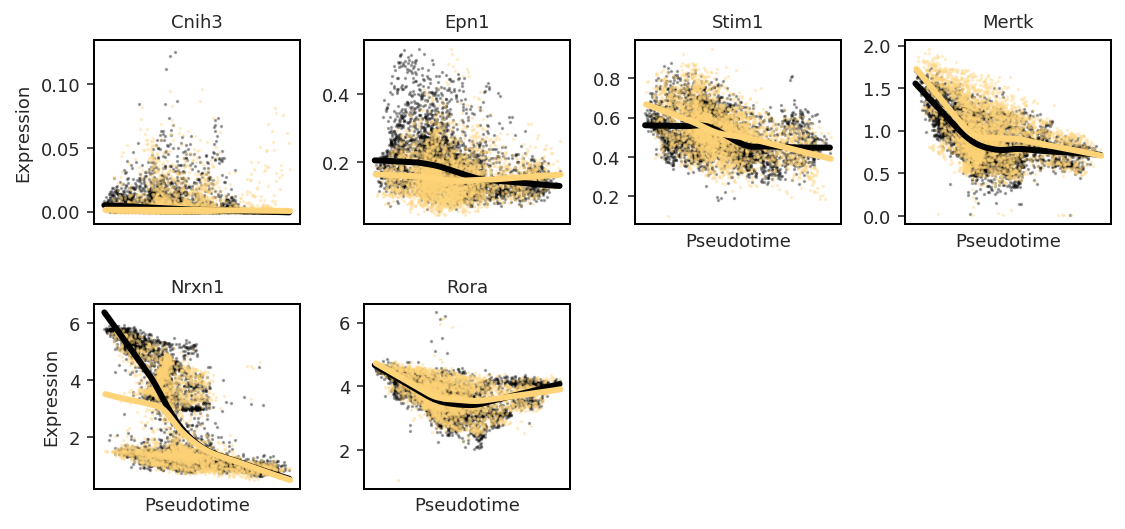

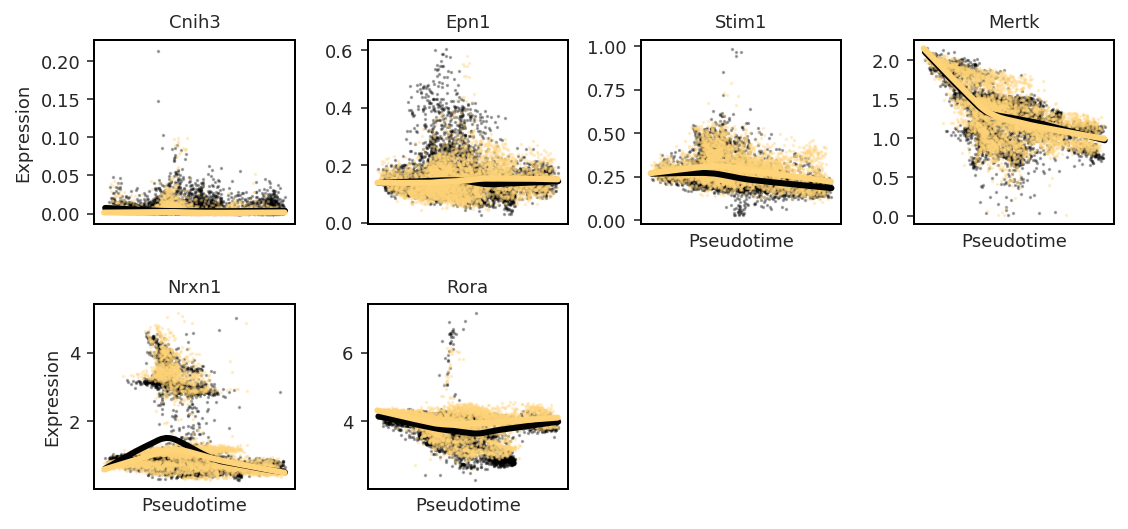

In [8]:
# plot

fname='v3'
x = X.melt(
    id_vars=['genotype','timepoint','ctype','Pseudotime'],
    value_vars=goi,
    var_name='Gene',
    value_name='Expression',
    col_level=None)


# aesthetics
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}

for i in goi_dict.keys():
    x_i = x.loc[(x['ctype']==i) & x['Gene'].isin(goi_dict[i]), :]

    p = sns.lmplot(
        x='Pseudotime',
        y='Expression',
        data=x_i,
        hue='genotype',
        col='Gene',
        palette=cmap_genotype,
        col_wrap=4,
        height=2,
        aspect=1,
        markers='o',
        sharex=False,
        sharey=False,
        hue_order=None,
        col_order=goi_dict[i],
        legend=False,
        legend_out=True,
        x_estimator=None,
        x_bins=None,
        x_ci='ci',
        scatter=True,
        fit_reg=True,
        ci=None,
        n_boot=100,
        units=None,
        seed=None,
        order=1,
        logistic=False,
        lowess=True,
        robust=False,
        logx=False,
        x_partial=None,
        y_partial=None,
        truncate=True,
        x_jitter=None,
        y_jitter=None,
        scatter_kws={'s':0.5,'alpha':0.33,'rasterized':True},
        line_kws={'linewidth':3},
        size=None,
    )
    p.set_titles(col_template = '{col_name}')
    p.set(xticks=[])
    for ax in p.axes.flatten(): # Loop directly on the flattened axes 
        for _, spine in ax.spines.items():
            spine.set_visible(True) # You have to first turn them on
            spine.set_color('black')
            spine.set_linewidth(1)

    p.savefig(os.path.join(pfp,'expVdyn_{}_{}.pdf'.format(fname, i)),bbox_inches='tight',dpi=300)

# Delete below

In [9]:
# aesthetics
# cmap_timepoint = {v:sns.light_palette((210, 90, 60), input="husl")[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_timepoint = {v:sns.color_palette('BuGn')[1:][i] for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk'])}

cmap_genotime = {}
for g in ['WT', 'SCA1']:
    if g=='WT':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5, start=.5, rot=-.75)[i]
    if g=='SCA1':
        for i,v in enumerate(['5wk', '12wk', '18wk', '24wk', '30wk']):
            cmap_genotime['{}_{}'.format(g, v)] = sns.cubehelix_palette(5)[i]
            
cmap_ctype={'Granule cell': '#FAC18A',
            'Unipolar brush cell': '#BA61BA',
            'Purkinje cell': '#EE5264',
            'GABAergic interneuron 1': '#F9EBAE',
            'GABAergic interneuron 2': '#88BB92',
            'GABAergic interneuron 3': '#46A928',
            'Astrocyte': '#F9AEAE',
            'Bergmann glia': '#AEB7F9',
            'Oligodendrocyte progenitor cell': '#F1815F',
            'Oligodendrocyte': '#75A3B7',
            'Microglia': '#AC5861',
            'Pericyte': '#2D284B',
            'Endothelial cell': '#1C67EE'}

cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}



In [10]:
if True:
    # do the human ones
    pdfp = '/home/ngr4/project/scnd/data/processed'
    pfp = '/home/ngr4/project/scnd/results/'

    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = utils.load_adata(os.path.join(pdfp, fname))
    
    if True : # not encoded yet
        hdata.obs['genotype']=['SCA1' if 'SCA' in i else 'WT' for i in hdata.obs['Sample']]

loaded @200814.16:08:01
took 10.88-s to load data
peak memory: 86372.95 MiB, increment: 9750.79 MiB


/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [13]:
hdata

AnnData object with n_obs × n_vars = 41150 × 27783
    obs: 'batch', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'n_genes', 'louvain', 'res_sca1', 'ees_sca1', 'ctype', 'genotype'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'ctype_colors', 'dendrogram_louvain', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_phate', 'X_umap'
    varm: 'PCs'
    layers: 'imputed_bbknn'
    obsp: 'distances', 'connectivities'

In [14]:
hdata.obs['ITGA6 (imputed)'] = hdata[:, 'ITGA6'].layers['imputed_bbknn']

[Text(0, 0, 'Granule cell'),
 Text(0, 0, 'Bergmann glia'),
 Text(0, 0, 'Oligodendrocyte'),
 Text(0, 0, 'Astrocyte'),
 Text(0, 0, 'GABAergic interneuron 1'),
 Text(0, 0, 'GABAergic interneuron 2'),
 Text(0, 0, 'Oligodendrocyte progenitor cell'),
 Text(0, 0, 'Pericyte'),
 Text(0, 0, 'Microglia')]

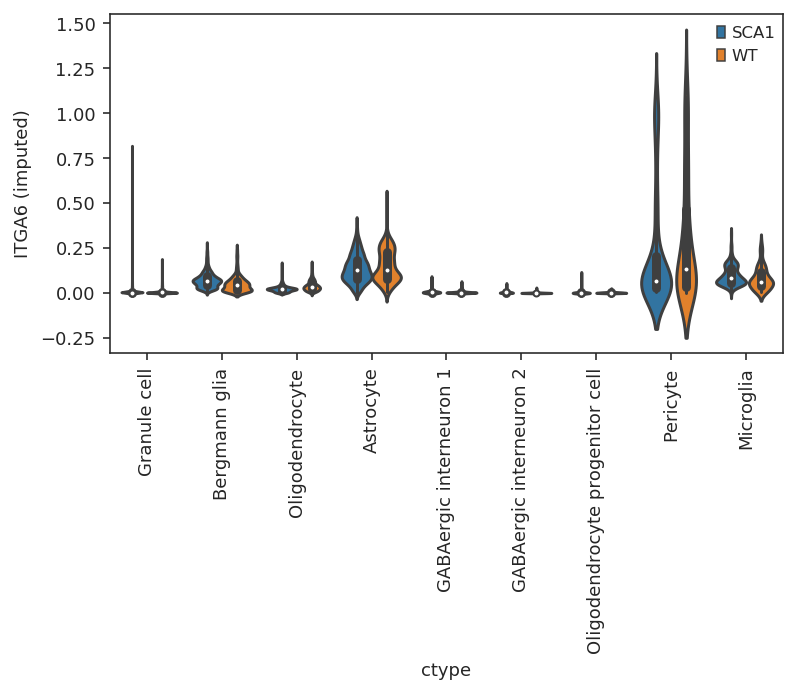

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
sns.violinplot(x='ctype', y='ITGA6 (imputed)', hue='genotype', dodge=True, data=hdata.obs, ax=ax)
ax.legend(bbox_to_anchor=(1.01,1.01))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)